# National Aggregate EPI Information

## 1. Webscraping Information and Creating Dataframe

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import os
import shutil

In [2]:
# Inputs
industry_vector = "National Aggregate"
start_year = 2009
end_year = 2018

# not inputs, but impacted by inputs
years = list(range(start_year,end_year + 1))
industry_folder_name = "National Aggregate EPI"
state = "national_aggregate"
path_name = industry_folder_name

In [3]:
if os.path.isdir(path_name):
    shutil.rmtree(path_name)
    os.makedirs(path_name)
    os.chdir(path_name)
    print("Directory already exists. Let's remove all the files.")
else:
    os.makedirs(path_name)
    os.chdir(path_name)
    print("Directory does not exist. We then make new directory.")

Directory already exists. Let's remove all the files.


In [4]:
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

In [5]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
s=Service(ChromeDriverManager().install())

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


In [6]:
def webscrape_df(year, state, industry_vector):
    driver = webdriver.Chrome(service=s)
    base_url = 'https://www.eeoc.gov/statistics/employment/jobpatterns/eeo1/'
    url = base_url + str(year)
    driver.get(url)
    element_dropdown = driver.find_element_by_id("edit-scope")
    select = Select(element_dropdown)
    # SELECTS OVERARCHING SECTION 
    dir(select)
    try:
        select.select_by_visible_text("National Aggregate, All Industries")
        driver.find_element_by_xpath('//*[(@id = "edit-submit")]').click()
    except NoSuchElementException:
        print('The item does not exist')

    # read html of page we navigated to
    html = driver.page_source
    driver.close() # we'll close the browser for now
    soup = BeautifulSoup(html, "html.parser")
    html_headers = soup.find_all(scope="col")
    headers = [html_headers[i].get_text() for i in range(len(html_headers))]

    # read ethnic groups from html & format for dataframe
    html_ethnic_groups = soup.find_all(scope="rowgroup")
    ethnic_groups = [html_ethnic_groups[i].get_text() for i in range(len(html_ethnic_groups))]
    ethnic_groups = np.repeat(ethnic_groups, 2)
    # read gender groups from html & format for dataframe
    html_gender_groups = soup.find_all(scope="row")
    gender_groups = [html_gender_groups[i].get_text() for i in range(len(html_gender_groups))]

    # getting the numbers for the dataframe
    html_data = soup.find_all("tr")
    data = [""]*len(ethnic_groups)
    count = 0
    for i in range(len(html_data)):
        temp_data = html_data[i].find_all("td")
        if len(temp_data) != 0:
            temp_list = [temp_data[i].get_text().replace(",","") for i in range(len(temp_data))]
            for j in range(len(temp_list)):
                if len(temp_list[j]) == 0:
                    temp_list[j] = 0
                else:
                    temp_list[j] = int(temp_list[j])
            data[count] = temp_list
            count +=1
        
    # combining everything into a dataframe
    final_df = pd.DataFrame(data, columns = headers[1:])
    final_df.index = ethnic_groups
    final_df.index.name = headers[0]
    
    final_df.index.name = "Racial/Ethnic_Group"

    final_df["entry_workers"] = final_df.iloc[:,3:11].sum(axis=1)
    # only need executives, managers, professionals, entry workers
    final_df = final_df.drop(
        columns=['Technicians',
           'Sales Workers', 'Office & Clerical Workers', 'Craft Workers',
           'Operatives', 'Laborers', 'Service Workers'],
        axis = 1,
    )
    final_df = final_df.fillna(0)
    
    # non gender separated df
    ethnic_df = final_df.groupby('Racial/Ethnic_Group')
    ethnic_df = ethnic_df.sum()
    totals = list(ethnic_df.sum(axis = 0, skipna = True))
    col_names = list(ethnic_df.columns)
    for i in range(len(ethnic_df.columns)):
        ethnic_df[col_names[i]] = ethnic_df[col_names[i]] / totals[i]
    ethnic_df['EPI'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['Professionals']
    ethnic_df['Managers_to_Execs'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['First/Mid Level Officials & Managers']
    ethnic_df['Professionals_to_Managers'] = ethnic_df['First/Mid Level Officials & Managers'] / ethnic_df['Professionals']
    ethnic_df['EPI_ew'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['entry_workers']
    ethnic_df['parity_diff'] = ethnic_df['EPI'] - 1
    print(year)
    return ethnic_df

This runs the webscraping algorithm for each year. It may take a few minutes to run.

In [7]:
# CREATING DATAFRAMES
df_list =  [""] * len(years)
for i in range(len(years)):
    df_list[i] = webscrape_df(years[i], state, industry_vector)

<ipython-input-6-b605390e4b32>:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element_dropdown = driver.find_element_by_id("edit-scope")
<ipython-input-6-b605390e4b32>:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//*[(@id = "edit-submit")]').click()


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [8]:
# the dataframe for the first year (default: 2009)
df_list[0]

,Executive/Senior Level Officials & Managers,First/Mid Level Officials & Managers,Professionals,entry_workers,EPI,Managers_to_Execs,Professionals_to_Managers,EPI_ew,parity_diff
Racial/Ethnic_Group,,,,,,,,,
AMERICAN INDIAN,0.002912,0.004010,0.003756,0.006231,0.775136,0.726131,1.067488,0.467269,-0.224864
ASIAN,0.040202,0.049099,0.105760,0.040924,0.380123,0.818791,0.464249,0.982348,-0.619877
BLACK,0.030431,0.070610,0.076033,0.165941,0.400239,0.430976,0.928681,0.183386,-0.599761
HAWAIIAN,0.001710,0.002170,0.003222,0.003917,0.530830,0.788346,0.673347,0.436679,-0.469170
HISPANIC,0.034913,0.067471,0.050079,0.165698,0.697152,0.517447,1.347291,0.210700,-0.302848
TWO OR MORE RACES,0.004160,0.005039,0.006464,0.008726,0.643558,0.825548,0.779552,0.476752,-0.356442
WHITE,0.885672,0.801602,0.754686,0.608563,1.173564,1.104879,1.062166,1.455351,0.173564


## 2. Organizing and Reformatting Dataframes

The EPI is defined as a ratio of the percentage representation of a company’s Executive workforce relative to that company’s percentage representation of itsentry-level Professional workforce. We use this metric and other related metrics to create the dataframes below.

**epi_df**: dataframe with all the different EPI by year and racial group

**parity_diff_df**: ratio of each group is expected to be 1. Contains all values of EPI except we subtract by 1.

**exec_df**: contains the proportion of executives to managers (% of executives from that group / % of manager from that group)

**manager_df**: contains the proportion of executives to managers (% of managers from that group / % of professionals from that group)

**epi_ew_df**: dataframe with al the different EPI by year and racial group; uses entry workers instead of just professionals (% of executives from that group / % of entry workers from that group)

**entry_df**: % of entry workers by group

In [9]:
# creating and.formatting dataframes
year = years[0]

epi_df = df_list[0]['EPI']
epi_df = epi_df.rename(str(year))

parity_diff_df = df_list[0]['parity_diff']
parity_diff_df = parity_diff_df.rename(str(year))

exec_df = df_list[0]['Managers_to_Execs']
exec_df = exec_df.rename(str(year))

managers_df =df_list[0]['Professionals_to_Managers']
managers_df = managers_df.rename(str(year))

epi_ew_df = df_list[0]['EPI_ew']
epi_ew_df = epi_ew_df.rename(str(year))

entry_df = df_list[0]['entry_workers']
entry_df = entry_df.rename(str(year))

for i in range(1,len(df_list)):
    year+=1
    temp1 = df_list[i]['parity_diff']
    temp1 = temp1.rename(str(year))
    parity_diff_df = pd.concat([parity_diff_df, temp1], axis = 1)
    temp2 = df_list[i]['EPI']
    temp2 = temp2.rename(str(year))
    epi_df = pd.concat([epi_df, temp2], axis = 1)
    temp3 = df_list[i]['Managers_to_Execs']
    temp3 = temp3.rename(str(year))
    exec_df = pd.concat([exec_df, temp3], axis = 1)
    temp5 = df_list[i]['EPI_ew']
    temp5 = temp5.rename(str(year))
    epi_ew_df = pd.concat([epi_ew_df, temp5], axis = 1)
    temp6 = df_list[i]['entry_workers']
    temp6 = temp6.rename(str(year))
    entry_df = pd.concat([entry_df, temp6], axis = 1)
    temp7 = df_list[i]['Professionals_to_Managers']
    temp7 = temp7.rename(str(year))
    managers_df = pd.concat([managers_df, temp7], axis = 1)
    

In [10]:
# more formatting dataframes and removing some info
drop_indices = ['AMERICAN INDIAN', 'HAWAIIAN', 'TWO OR MORE RACES']
parity_diff_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)
epi_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)
exec_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)
epi_ew_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)
entry_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)
managers_df.drop(
    labels=drop_indices,
    axis = 0,
    inplace=True)

In [11]:
# saves epi_df
csv_title = state + "_epi.csv"
rounded_epi_df = epi_df.round(decimals=3)
rounded_epi_df.to_csv(csv_title)

In [12]:
# save epi_df but transposed
csv_title = state + "_epi_transpose.txt"
rounded_epi_df = epi_df.round(decimals=3)
rounded_epi_df.transpose().to_csv(csv_title)

In [13]:
epi_df

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Racial/Ethnic_Group,,,,,,,,,,
ASIAN,0.380123,0.385280,0.382965,0.375068,0.397739,0.415224,0.415891,0.486593,0.449300,0.474603
BLACK,0.400239,0.409576,0.391145,0.391690,0.384262,0.409891,0.409704,0.406226,0.402559,0.408769
HISPANIC,0.697152,0.731635,0.691933,0.675089,0.654502,0.668961,0.756372,0.711341,0.658749,0.641779
WHITE,1.173564,1.171839,1.181869,1.188545,1.193509,1.193115,1.191917,1.191503,1.215939,1.225746


## 3. Creating Visualizations

In [14]:
import matplotlib.pyplot as plt

In [15]:
# formatting for later plotting
epi_df = epi_df.transpose()
parity_diff_df = parity_diff_df.transpose()
exec_df = exec_df.transpose()
epi_ew_df = epi_ew_df.transpose()
entry_df = entry_df.transpose()
managers_df = managers_df.transpose()

In [16]:
epi_df.iloc[:,0]

2009    0.380123
2010    0.385280
2011    0.382965
2012    0.375068
2013    0.397739
2014    0.415224
2015    0.415891
2016    0.486593
2017    0.449300
2018    0.474603
Name: ASIAN, dtype: float64

### EPI Graph

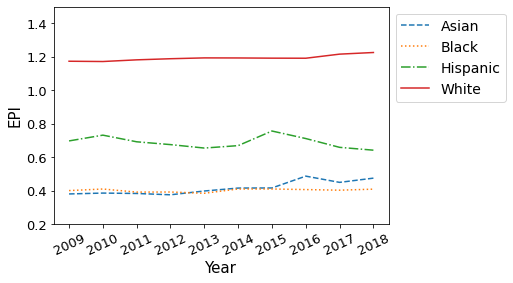

In [17]:
years = epi_df.index

axes = plt.axes()
axes.set_ylim([.2, 1.5])

plt.plot(years, epi_df.iloc[:,0], linestyle="dashed")
plt.plot(years, epi_df.iloc[:,1], linestyle="dotted")
plt.plot(years, epi_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, epi_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('EPI', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
name = state+"_EPI.png"
plt.savefig(name, bbox_inches = 'tight')
plt.show()

### Parity Graph
The epi graph but subtract 1 so that 0 is the baseline/target

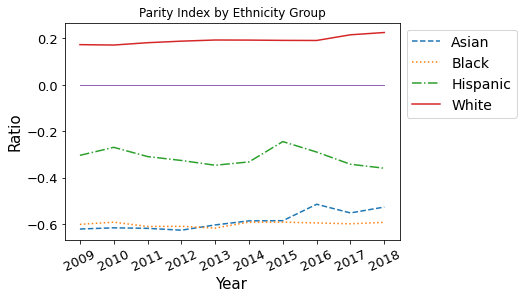

In [18]:
years = parity_diff_df.index

axes = plt.axes()

plt.plot(years, parity_diff_df.iloc[:,0], linestyle="dashed")
plt.plot(years, parity_diff_df.iloc[:,1], linestyle="dotted")
plt.plot(years, parity_diff_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, parity_diff_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
plt.title('Parity Index by Ethnicity Group')
name = state+"_parity.png"
plt.savefig(name, bbox_inches = 'tight')
plt.plot([0,9], [0, 0], '-', lw=1)
plt.show()

### Professional to Manager Parity Index by Racial Group

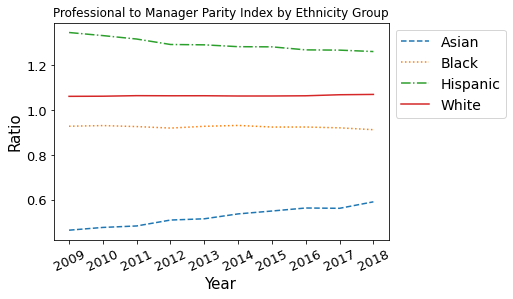

In [19]:
# graph of ethnicity breakdown for asian professionals to asian managers ratio throughout the years
years = managers_df.index

axes = plt.axes()

plt.plot(years, managers_df.iloc[:,0], linestyle="dashed")
plt.plot(years, managers_df.iloc[:,1], linestyle="dotted")
plt.plot(years, managers_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, managers_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
plt.title('Professional to Manager Parity Index by Ethnicity Group')
name = state+"_Managers.png"
plt.savefig(name, bbox_inches = 'tight')
plt.show()

### Managers to Executive Parity Index by Ethnicity Group

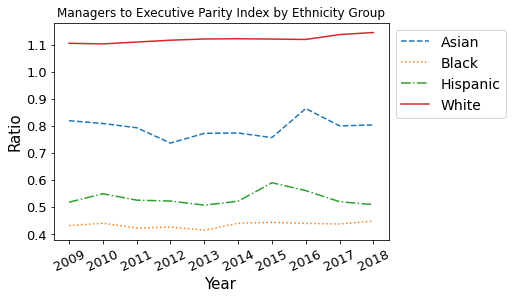

In [20]:
# graph of ethnicity breakdown for asian managers to asian executives ratio throughout the years
years = exec_df.index

axes = plt.axes()

plt.plot(years, exec_df.iloc[:,0], linestyle="dashed")
plt.plot(years, exec_df.iloc[:,1], linestyle="dotted")
plt.plot(years, exec_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, exec_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
plt.title('Managers to Executive Parity Index by Ethnicity Group')
name = state+"_Executives.png"
plt.savefig(name, bbox_inches = 'tight')
plt.show()

### Executive Parity Index by Ethnicity Group (Entry Level)
- assumption before was professionals were lowest level
- assumption here is that all other columns other than managers and execs are grouped in one level

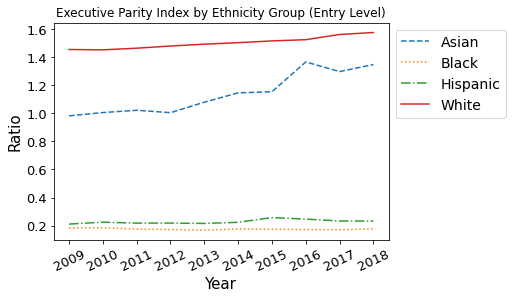

In [21]:
# graph of ethnicity breakdown for asian professionals to asian managers ratio throughout the years
years = epi_ew_df.index

axes = plt.axes()

plt.plot(years, epi_ew_df.iloc[:,0], linestyle="dashed")
plt.plot(years, epi_ew_df.iloc[:,1], linestyle="dotted")
plt.plot(years, epi_ew_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, epi_ew_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
plt.title('Executive Parity Index by Ethnicity Group (Entry Level)')
# won't save
# name = state+"_epi_ew.png" # ew is for entry workers
# plt.savefig(name, bbox_inches = 'tight')
plt.show()

### Entry Level Ratio by Ethnicity Group (Entry Level)

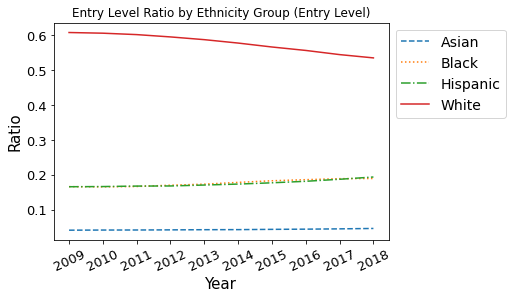

In [22]:
# graph of ethnicity breakdown for asian professionals to asian managers ratio throughout the years
years = entry_df.index

axes = plt.axes()

plt.plot(years, entry_df.iloc[:,0], linestyle="dashed")
plt.plot(years, entry_df.iloc[:,1], linestyle="dotted")
plt.plot(years, entry_df.iloc[:,2], linestyle="dashdot")
plt.plot(years, entry_df.iloc[:,3])
columns = ["Asian", "Black", "Hispanic", "White"]
plt.legend(labels = columns, fontsize=14, bbox_to_anchor=(1, 1))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Ratio', fontsize= 15)
plt.xticks(fontsize = 13, rotation =25)
plt.yticks(fontsize = 13)
plt.title('Entry Level Ratio by Ethnicity Group (Entry Level)')
# won't save
# name = state+"_entry.png" # ew is for entry workers
# plt.savefig(name, bbox_inches = 'tight')
plt.show()

## 4. Data Analysis (Tests for Significance)

In [23]:
# Welch's t test (variances not equal, sample size less than 10)
import scipy
from scipy import stats
white_epi = epi_df["WHITE"]
asian_epi = epi_df["ASIAN"]
hispanic_epi = epi_df["HISPANIC"]
black_epi = epi_df["BLACK"]

black_test = scipy.stats.ttest_ind(a=black_epi, b=asian_epi, equal_var=False, alternative = 'greater')
hispanic_test = scipy.stats.ttest_ind(a=hispanic_epi, b=asian_epi, equal_var=False, alternative = 'greater')
white_test = scipy.stats.ttest_ind(a=white_epi, b=asian_epi, equal_var=False, alternative = 'greater')
t_statistic = np.array([black_test[0], hispanic_test[0], white_test[0]])
p_value = np.array([black_test[1], hispanic_test[1], white_test[1]])
t_test_df = pd.DataFrame({'t statistic': t_statistic, 'p value': p_value}, columns=['t statistic', 'p value'], index = ["Black", "Hispanic", "White"])
new_name = state + "_ttest.png"
t_test_df = t_test_df.round(3) # rounding values for visual purposes

import dataframe_image as dfi 
dfi.export(t_test_df, new_name)

In [24]:
significance_count = sum(t_test_df.iloc[:,1] < .05)
print(significance_count)

2
